<a href="https://colab.research.google.com/github/MiguelDavid0426/Segunda-entrega-algoritmos-geneticos/blob/main/Aplicaci%C3%B3n_AG_Sistemas_Inteligentes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pygad

In [ ]:
pip install Keras-Applications

In [ ]:
pip install torchvision 

# Importación de librerias

In [ ]:
import torch
#import torchga
import pygad

In [ ]:
#Librerias
import cv2
from google.colab.patches import cv2_imshow
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import shutil
from sklearn.model_selection import train_test_split

#Otras librerias necesarias de keras

from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
#from tensorflow.python.keras.applications import ResNet50
#from tensorflow.python.keras.models import Sequential
#from tensorflow.python.keras.layers import Dense

# Librerias para algoritmos geneticos
import tensorflow.keras
import pygad.kerasga
import pygad
import tensorflow as tf

from keras.utils.vis_utils import plot_model

#Carga de los datos

**ACCESO A GOOGLE DRIVE para Cargar Data**

In [ ]:
#Montar google drive
from google.colab import drive
#drive.mount('/content/drive')

#% cd /content/drive/MyDrive/Colab Notebooks
#Acá debemos cargar los archivos de imagenes y etiquetas en google drive

#Cargar etiquetas
lab=np.load('labels.npy')

#Cargar imagenes
img=np.load('Imagenes_gris_240.npy')

In [ ]:
nombre_gpu = tf.test.gpu_device_name()
if nombre_gpu != '/device:GPU:0':
  raise SystemError("GPU no encontrada")
print('GPU encontrada: {}'.format(nombre_gpu))

Aqui validamos la usabilidad del GPU en el entorno

In [ ]:
img.shape

(2000, 240, 240)

In [ ]:
lab.shape

(2000, 1)

# Entendimiento de los datos

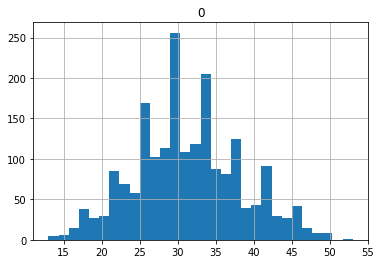

In [ ]:
label=pd.DataFrame(lab)
label
label.hist(bins=30);

Podemos ver que la distribución de los conteos de objetos tienen una similitud a una normal, a continuación vemos los parametros de esta

In [ ]:
label.describe()

,0
count,2000.000000
mean,31.157500
std,6.945417
min,13.000000
25%,26.000000
50%,31.000000
75%,36.000000
max,53.000000


La media y la mediana son cercanas por lo que se puede esperar que los datos se distribuyan de manera normal con media de 30 personas por imagen.

**Ver una imagen**

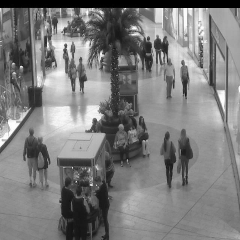

In [ ]:
img_gris = cv2.resize(img[1390], (240,240))
cv2_imshow(img_gris)

Realizamos una pequeña visualización del dataset

# Procesamiento de los datos

Se separa en validación y prueba

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(img, lab, test_size=0.2)
print(x_train.shape)
print(x_test.shape)

(1600, 240, 240)
(400, 240, 240)


Se aumenta una dimensión del objeto matricial

In [ ]:
train_X = x_train.reshape(-1, 240,240, 1)
test_X = x_test.reshape(-1, 240,240, 1)
train_X.shape, test_X.shape

((1600, 240, 240, 1), (400, 240, 240, 1))

Se normalizan los pixeles para poder mejorar el proceso de optimización

In [ ]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255.
test_X = test_X / 255.

# Contrucción del modelo

# Protocolo experimental: Cuadro Latino


Aqui se proceden a realizar las diferentes arquitecturas expuestas en el documento entregable, para determiner cual es la mejor configuración de red

In [ ]:
# Build the keras model using the functional API.
# https://pygad.readthedocs.io/en/latest/README_pygad_ReadTheDocs.html#pygad-ga-class

input_layer = tensorflow.keras.layers.Input(shape=(240, 240, 1))
conv_layer1 = tensorflow.keras.layers.Conv2D(filters=32,
                                             kernel_size=3,
                                             activation="relu")(input_layer)
max_pool1 = tensorflow.keras.layers.MaxPooling2D(pool_size=(2,2),
                                                 strides=3)(conv_layer1)
conv_layer2 = tensorflow.keras.layers.Conv2D(filters=16,
                                             kernel_size=3,
                                             activation="relu")(max_pool1)

max_pool11 = tensorflow.keras.layers.MaxPooling2D(pool_size=(2,2),
                                                 strides=3)(conv_layer2)
conv_layer22 = tensorflow.keras.layers.Conv2D(filters=8,
                                             kernel_size=3,
                                             activation="relu")(max_pool11)

flatten_layer  = tensorflow.keras.layers.Flatten()(conv_layer22)
dense_layer = tensorflow.keras.layers.Dense(8, activation="relu")(flatten_layer)
output_layer = tensorflow.keras.layers.Dense(8, activation="linear")(dense_layer)

model = tensorflow.keras.Model(inputs=input_layer, outputs=output_layer)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 240, 240, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 238, 238, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 79, 79, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 77, 77, 16)        4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 26, 26, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 8)         1160      
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0     

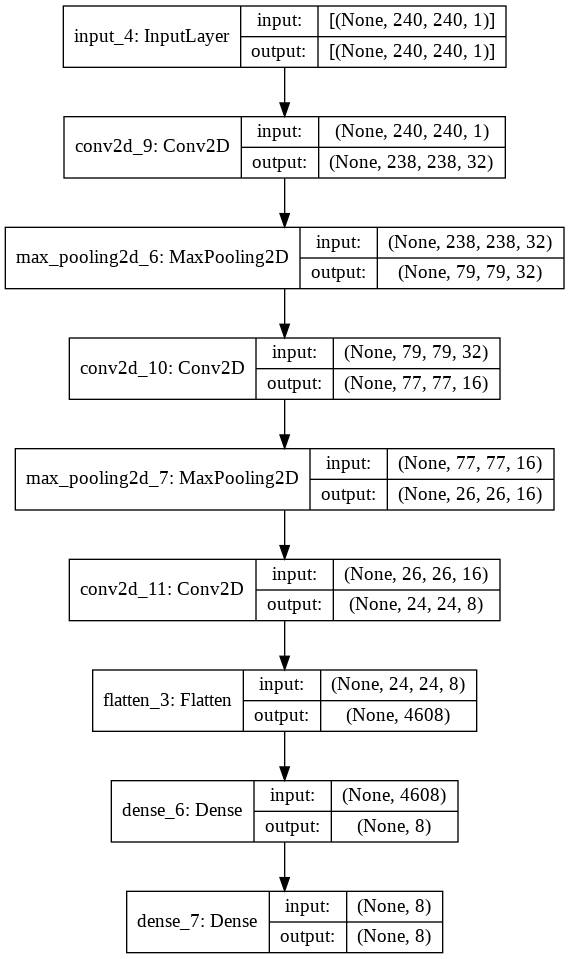

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Implementación del entrenamiento del AG

In [ ]:
import pygad.kerasga
keras_ga = pygad.kerasga.KerasGA(model=model,
                                 num_solutions=5)

def fitness_func(solution, sol_idx):
    global data_inputs, data_outputs, keras_ga, model
    model_weights_matrix = pygad.kerasga.model_weights_as_matrix(model=model,
                                                                 weights_vector=solution)
    model.set_weights(weights=model_weights_matrix)
    predictions = model.predict(data_inputs)

    mae = tensorflow.keras.losses.MeanAbsoluteError()
    abs_error = mae(data_outputs, predictions).numpy() + 0.00000001
    solution_fitness = 1.0 / abs_error

    print(solution_fitness, abs_error)
    return solution_fitness

def callback_generation(ga_instance):
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))

In [ ]:
# Data inputs
data_inputs = x_train

# Data outputs
data_outputs = y_train

ga_instance = pygad.GA(num_generations=500, 
                       num_parents_mating=4, 
                       initial_population=keras_ga.population_weights,
                       fitness_func=fitness_func,
                       callback_generation=callback_generation,
                       crossover_type="scattered",
                       mutation_type="random",
                       parent_selection_type = "sss",
                       mutation_percent_genes=35)

/usr/local/lib/python3.7/dist-packages/pygad/pygad.py:731: UserWarning: Starting from PyGAD 2.6.0, the callback_generation parameter is deprecated and will be removed in a later release of PyGAD. Please use the on_generation parameter instead.
  if not self.suppress_warnings: warnings.warn("Starting from PyGAD 2.6.0, the callback_generation parameter is deprecated and will be removed in a later release of PyGAD. Please use the on_generation parameter instead.")


In [ ]:
ga_instance.run()

0.0360929477537129 27.70624352501465
2.496442764095692e-06 400569.96875001
7.125004077394403e-06 140350.79687501
1.1683133343341737e-05 85593.47656251
5.849643861799262e-06 170950.57812501
1.4525463875793372e-05 68844.61718751
Generation = 1
1.4525463875793372e-05 68844.61718751
Fitness    = 0.0360929477537129
3.6187076328494113e-06 276341.75000001
Generation = 2
3.6187076328494113e-06 276341.75000001
Fitness    = 0.0360929477537129
9.730699841054154e-06 102767.53125001
Generation = 3
9.730699841054154e-06 102767.53125001
Fitness    = 0.0360929477537129
7.1364685698210816e-06 140125.32812501
Generation = 4
7.1364685698210816e-06 140125.32812501
Fitness    = 0.0360929477537129
7.4945752156734045e-06 133429.84375001
Generation = 5
7.4945752156734045e-06 133429.84375001
Fitness    = 0.0360929477537129
6.687661744756165e-06 149529.09375001
Generation = 6
6.687661744756165e-06 149529.09375001
Fitness    = 0.0360929477537129
1.178230570149316e-05 84873.03125001
Generation = 7
1.1782305701493

/usr/local/lib/python3.7/dist-packages/pygad/pygad.py:3135: UserWarning: Please use the plot_fitness() method instead of plot_result(). The plot_result() method will be removed in the future.
  warnings.warn("Please use the plot_fitness() method instead of plot_result(). The plot_result() method will be removed in the future.")


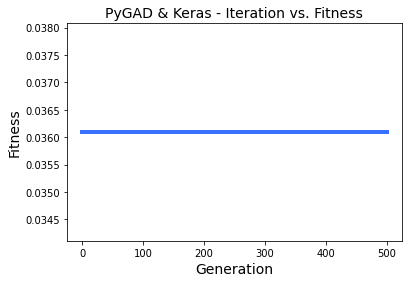

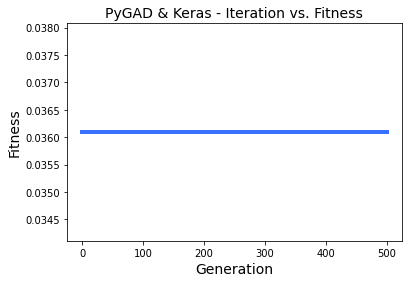

In [ ]:
# After the generations complete, some plots are showed that summarize how the outputs/fitness values evolve over generations.
ga_instance.plot_result(title="PyGAD & Keras - Iteration vs. Fitness", linewidth=4)

In [ ]:
# Returning the details of the best solution.
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

7.881205602797699e-06 126884.14062501
Fitness value of the best solution = 0.0360929477537129
Index of the best solution : 0


In [ ]:
# Fetch the parameters of the best solution.
best_solution_weights = pygad.kerasga.model_weights_as_matrix(model=model,
                                                              weights_vector=solution)

In [ ]:
#### MAE con datos de entrenamiento
model.set_weights(best_solution_weights)
predictions = model.predict(data_inputs)
print("Predictions : \n", predictions)

mae = tensorflow.keras.losses.MeanAbsoluteError()
abs_error = mae(data_outputs, predictions).numpy()
print("Absolute Error : ", abs_error)

Predictions : 
 [[ 1.847695    6.8061166   1.6579949  ...  8.676185   -4.044934
   0.99116236]
 [ 3.2030308   8.701344    2.0546374  ...  9.122029   -3.8974586
   2.0493846 ]
 [ 3.8464987   9.168078    2.1283622  ...  8.506199   -3.3919687
   2.598098  ]
 ...
 [ 5.083789   10.11604     2.0537517  ...  8.7799     -2.9098976
   3.038463  ]
 [ 5.3018813  10.487913    2.365015   ...  7.6181397  -2.5143216
   3.8109186 ]
 [ 4.99414    10.222881    2.3186917  ...  7.832763   -2.7140267
   3.5529652 ]]
Absolute Error :  27.706244


In [ ]:
#### MAE con datos de prueba
test_X = x_test.reshape(-1, 240,240, 1)
model.set_weights(best_solution_weights)
predictions = model.predict(test_X)
print("Predictions : \n", predictions)

mae = tensorflow.keras.losses.MeanAbsoluteError()
abs_error = mae(y_test, predictions).numpy()
print("Absolute Error : ", abs_error)

Predictions : 
 [[ 3.6863308  9.402823   2.2028663 ...  9.330047  -3.8706746  2.4239929]
 [ 3.8780668  9.607916   2.2423027 ...  9.272696  -3.7864385  2.5804355]
 [ 3.5827842  9.62028    2.268416  ...  9.988192  -4.2462153  2.3044116]
 ...
 [ 2.726147   9.316424   2.254279  ... 11.41473   -5.238437   1.5399703]
 [ 3.224704  10.588029   2.5521843 ... 12.676419  -5.761847   1.8678111]
 [ 4.3809047  9.988945   2.3956919 ...  8.516974  -3.9316773  1.8720444]]
Absolute Error :  27.775488


In [ ]:
#### Desde aquí comienzan otros algoritmos geneticos

In [ ]:
train_inputs = data_inputs
train_outputs = data_outputs

In [ ]:
import pygad.cnn

input_layer = pygad.cnn.Input2D(input_shape=(240, 240, 1))

conv_layer = pygad.cnn.Conv2D(num_filters=2,
                              kernel_size=3,
                              previous_layer=input_layer,
                              activation_function="relu")
average_pooling_layer = pygad.cnn.AveragePooling2D(pool_size=5,
                                                   previous_layer=conv_layer,
                                                   stride=3)

flatten_layer = pygad.cnn.Flatten(previous_layer=average_pooling_layer)
dense_layer = pygad.cnn.Dense(num_neurons=4,
                              previous_layer=flatten_layer,
                              activation_function="sigmoid")

In [ ]:
model = pygad.cnn.Model(
                        last_layer=dense_layer,
                        epochs=3,
                        learning_rate=0.01)

In [ ]:
model.summary()


----------Network Architecture----------
<class 'pygad.cnn.cnn.Conv2D'>
<class 'pygad.cnn.cnn.AveragePooling2D'>
<class 'pygad.cnn.cnn.Flatten'>
<class 'pygad.cnn.cnn.Dense'>
----------------------------------------



In [ ]:
model.train(train_inputs=train_inputs,
            train_outputs=train_outputs)

Epoch 0
Epoch 1
Epoch 2


In [ ]:
import pygad.gacnn

GACNN_instance = pygad.gacnn.GACNN(model=model,
                                   num_solutions=3)

In [ ]:
import pygad.nn
import pygad.gann

def fitness_func(solution, sol_idx):
    global GACNN_instance, data_inputs, data_outputs

    predictions = pygad.nn.predict(last_layer=GACNN_instance.population_networks[sol_idx],
                                   data_inputs=data_inputs)
    
    mae = tensorflow.keras.losses.MeanAbsoluteError()
    abs_error = mae(data_outputs, predictions) + 0.012
    solution_fitness = 1.0 / abs_error

    return solution_fitness

In [ ]:
population_vectors = pygad.gacnn.population_as_vectors(population_networks=GACNN_instance.population_networks)

initial_population = population_vectors.copy()

num_parents_mating = 2

num_generations = 10

mutation_percent_genes = 0.1

parent_selection_type = "sss"

crossover_type = "single_point"

mutation_type = "random"

keep_parents = -1

In [ ]:
ga_instance = pygad.GA(num_generations=num_generations, 
                       num_parents_mating=num_parents_mating, 
                       initial_population=initial_population,
                       fitness_func=fitness_func,
                       mutation_percent_genes=mutation_percent_genes,
                       parent_selection_type=parent_selection_type,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       keep_parents=keep_parents,
                       callback_generation=callback_generation)

/usr/local/lib/python3.7/dist-packages/pygad/pygad.py:731: UserWarning: Starting from PyGAD 2.6.0, the callback_generation parameter is deprecated and will be removed in a later release of PyGAD. Please use the on_generation parameter instead.
  if not self.suppress_warnings: warnings.warn("Starting from PyGAD 2.6.0, the callback_generation parameter is deprecated and will be removed in a later release of PyGAD. Please use the on_generation parameter instead.")


In [ ]:
def callback_generation(ga_instance):
    global GACNN_instance, last_fitness

    population_matrices = pygad.gacnn.population_as_matrices(population_networks=GACNN_instance.population_networks, population_vectors=ga_instance.population)

    GACNN_instance.update_population_trained_weights(population_trained_weights=population_matrices)

In [ ]:
ga_instance.run()

In [ ]:
import torch
import torchga
import pygad

def fitness_func(solution, sol_idx):
    global data_inputs, data_outputs, torch_ga, model, loss_function

    model_weights_dict = torchga.model_weights_as_dict(model=model,
                                                       weights_vector=solution)

    # Use the current solution as the model parameters.
    model.load_state_dict(model_weights_dict)

    predictions = model(data_inputs)
    abs_error = loss_function(predictions, data_outputs).detach().numpy() + 0.00000001

    solution_fitness = 1.0 / abs_error

    return solution_fitness

def callback_generation(ga_instance):
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))

# Create the PyTorch model.
input_layer = torch.nn.Conv2d(240, 240, 1, stride=2)
relu_layer = torch.nn.ReLU()
output_layer = torch.nn.Linear(120, 1)

model = torch.nn.Sequential(input_layer,
                            relu_layer,
                            output_layer)
# print(model)

# Create an instance of the pygad.torchga.TorchGA class to build the initial population.
torch_ga = torchga.TorchGA(model=model,
                           num_solutions=10)

loss_function = torch.nn.L1Loss()


# Prepare the PyGAD parameters. Check the documentation for more information: https://pygad.readthedocs.io/en/latest/README_pygad_ReadTheDocs.html#pygad-ga-class
num_generations = 20 # Number of generations.
num_parents_mating = 5 # Number of solutions to be selected as parents in the mating pool.
initial_population = torch_ga.population_weights # Initial population of network weights
parent_selection_type = "sss" # Type of parent selection.
crossover_type = "single_point" # Type of the crossover operator.
mutation_type = "random" # Type of the mutation operator.
mutation_percent_genes = 10 # Percentage of genes to mutate. This parameter has no action if the parameter mutation_num_genes exists.
keep_parents = -1 # Number of parents to keep in the next population. -1 means keep all parents and 0 means keep nothing.

ga_instance = pygad.GA(num_generations=num_generations, 
                       num_parents_mating=num_parents_mating, 
                       initial_population=initial_population,
                       fitness_func=fitness_func,
                       parent_selection_type=parent_selection_type,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       keep_parents=keep_parents,
                       on_generation=callback_generation)

ga_instance.run()

# After the generations complete, some plots are showed that summarize how the outputs/fitness values evolve over generations.
ga_instance.plot_result(title="PyGAD & PyTorch - Iteration vs. Fitness", linewidth=4)

# Returning the details of the best solution.
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

# Fetch the parameters of the best solution.
best_solution_weights = torchga.model_weights_as_dict(model=model,
                                                      weights_vector=solution)
model.load_state_dict(best_solution_weights)
predictions = model(data_inputs)
print("Predictions : \n", predictions.detach().numpy())

abs_error = loss_function(predictions, data_outputs)
print("Absolute Error : ", abs_error.detach().numpy())